In [6]:
## Importing libraries

!pip install librosa
!pip install tqdm
!pip install plotly
import os
import random
import sys
import glob
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import warnings
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import plotly.offline as py

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
py.init_notebook_mode(connected=True)

Using legacy 'setup.py install' for retrying, since package 'wheel' is not installed.
    Running setup.py install for retrying: started
    Running setup.py install for retrying: finished with status 'done'


In [129]:
## Loading Data
def metadata(basepath):
    dir_list = os.listdir(basepath)
    dir_list.sort()

    ## DataFrame to save metadata of Ravdess audio files
    df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repetition', 'emotion'])
    count = 0

    ## Iterating through the directory, reading audio files, and extracting information from the file name
    for f in os.listdir(basepath):
        filename = f.split('.')[0].split('-')
        if(len(filename)==7):
            path = basepath + f
            src = int(filename[1])
            actor = int(filename[-1])
            emotion = int(filename[2])
            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if filename[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if filename[4] == '01':
                statement = 0
            else:
                statement = 1

            if filename[5] == '01':
                repeat = 0
            else:
                repeat = 1

            df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1
        
    labels = []
    y=[]
    for i in range(len(df)):
        if df.emotion.iloc[i] == 1:
            label = "_neutral"
            y.append(1)
        elif df.emotion.iloc[i] == 2:
            label = "_calm"
            y.append(2)
        elif df.emotion.iloc[i] == 3:
            label = "_happy"
            y.append(3)
        elif df.emotion.iloc[i] == 4:
            label = "_sad"
            y.append(4)
        elif df.emotion.iloc[i] == 5:
            label = "_angry"
            y.append(5)
        elif df.emotion.iloc[i] == 6:
            label = "_fearful"
            y.append(6)
        elif df.emotion.iloc[i] == 7:
            label = "_disgust"
            y.append(7)
        elif df.emotion.iloc[i] == 8:
            label = "_surprised"
            y.append(8)
        else:
            label = "_none"

        # Add gender to the label 
        labels.append(label)

    df['label'] = labels
    
    return df

In [ ]:
df = metadata("C:/Users/Shireen/A FINAL SER ATTEMPT/data/wavfiles")

In [146]:
y = df.emotion.values.tolist()

In [184]:
class Spectrograms():
    def __init__(self, df, datasettype, outputpath, sample=False, augmentation=False, mel=True, mfcc=False, spectral=False, mfccbanks=20, n_mels=128):
        self.df = df
        self.augmentation = augmentation
        self.mel = mel
        self.mfcc = mfcc
        self.spectral = spectral
        self.mfccbanks = mfccbanks
        self.n_mels = n_mels
        self.outputpath = outputpath
        self.datasettype = datasettype
        self.sample = sample
        
    def get_spectrograms(self):
        if self.sample:
            x, sample_rate = librosa.load(self.df.index[0])
            self.generate(x, sample_rate, '', 0)
        
        else:
            for file in tqdm(range(self.df.shape[0])):
                emotion = df.iloc[file, df.columns.get_loc('label')]
                path = self.outputpath+self.datasettype+"/"+str(emotion)+"/"

                if not os.path.isdir(path):
                    os.makedirs(path)

                ## Reading signal from .wav file
                x, sample_rate = librosa.load(self.df.index[file])
                emo = df.iloc[file, df.columns.get_loc('emotion')]
                self.generate(x, sample_rate, path, file, emo)

        
    def generate(self, x, sample_rate, path, count, emo):
        if self.mel:
            mel_features = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=self.n_mels)
            log_mel_features = librosa.power_to_db(mel_features, ref=np.max)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(log_mel_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+emo+"-"+str(count)+".jpg")
                plt.close()
            
        if self.mfcc:
            mfcc_features = librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=self.mfccbanks)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(mfcc_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"mfccspectrogram_"+str(count)+".jpg")
                plt.close()
            
        if self.spectral:
            spectral_features = librosa.feature.spectral_contrast(x, sr=sample_rate)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(spectral_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"spectralspectrogram_"+str(count)+".jpg")
                plt.close()


In [185]:
df_new = metadata("C:/Users/Shireen/A FINAL SER ATTEMPT/data/wavfiles/")

In [187]:
df_new.index = df_new.path
df_new = df_new.drop("path", axis=1)

In [173]:
spectrograms = Spectrograms(df_new, 'images_new', 'C:/Users/Shireen/A FINAL SER ATTEMPT/data/spectograms/', sample=False)
spectrograms.get_spectrograms()

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [06:11<00:00,  3.88it/s]


In [1]:
!pip install opencv-python
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
categories = os.listdir("C:/Users/Shireen/A FINAL SER ATTEMPT/data/spectograms/images/")
len(categories)

8

In [3]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

fpath = "C:/Users/Shireen/A FINAL SER ATTEMPT/data/spectograms/images/"
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))


No. of images loaded =  1440 
No. of labels loaded =  1440
<class 'list'> <class 'list'>


In [4]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1440, 227, 227, 3) 
Labels shape =  (1440,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [5]:
#1-step in data shuffling
random_seed=42
#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1437 1438 1439]

'n' values after shuffling =  [ 168  605  548 ... 1294  860 1126]


In [6]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1440, 227, 227, 3) 
Labels shape after shuffling =  (1440,)


In [7]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1440, 227, 227, 3)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1152, 227, 227, 3)
y_train shape =  (1152,)

x_test shape =  (288, 227, 227, 3)
y_test shape =  (288,)


In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

In [53]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 9, 9, 384)        

In [54]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [206]:
%%time
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
36/36 [==============================] - 70s 2s/step - loss: 2.5159 - accuracy: 0.2309
Epoch 2/100
36/36 [==============================] - 69s 2s/step - loss: 2.0505 - accuracy: 0.3333
Epoch 3/100
36/36 [==============================] - 68s 2s/step - loss: 1.8162 - accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 68s 2s/step - loss: 1.7086 - accuracy: 0.4158
Epoch 5/100
36/36 [==============================] - 69s 2s/step - loss: 1.5923 - accuracy: 0.4688
Epoch 6/100
36/36 [==============================] - 69s 2s/step - loss: 1.5468 - accuracy: 0.4592
Epoch 7/100
36/36 [==============================] - 68s 2s/step - loss: 1.5436 - accuracy: 0.4861
Epoch 8/100
36/36 [==============================] - 74s 2s/step - loss: 1.3983 - accuracy: 0.5078
Epoch 9/100
36/36 [==============================] - 82s 2s/step - loss: 1.2994 - accuracy: 0.5130
Epoch 10/100
36/36 [==============================] - 75s 2s/step - loss: 1.1701 - accuracy: 0.5868
Epoch 11/

36/36 [==============================] - 70s 2s/step - loss: 0.0312 - accuracy: 0.9861
Epoch 84/100
36/36 [==============================] - 71s 2s/step - loss: 0.0485 - accuracy: 0.9826
Epoch 85/100
36/36 [==============================] - 73s 2s/step - loss: 0.0587 - accuracy: 0.9835
Epoch 86/100
36/36 [==============================] - 71s 2s/step - loss: 0.0595 - accuracy: 0.9826
Epoch 87/100
36/36 [==============================] - 67s 2s/step - loss: 0.0496 - accuracy: 0.9835
Epoch 88/100
36/36 [==============================] - 65s 2s/step - loss: 0.0583 - accuracy: 0.9774
Epoch 89/100
36/36 [==============================] - 66s 2s/step - loss: 0.0548 - accuracy: 0.9800
Epoch 90/100
36/36 [==============================] - 66s 2s/step - loss: 0.0457 - accuracy: 0.9878
Epoch 91/100
36/36 [==============================] - 62s 2s/step - loss: 0.0240 - accuracy: 0.9939
Epoch 92/100
36/36 [==============================] - 61s 2s/step - loss: 0.0150 - accuracy: 0.9939
Epoch 93/100


In [207]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.9927990436553955
Test accuracy: 0.5416666865348816


In [208]:
predictions = model.predict_classes(x_test)
predictions
y_test
new_Ytest = y_test.astype(int)
new_Ytest

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([7, 7, 5, 7, 1, 4, 1, 1, 7, 1, 7, 6, 7, 4, 7, 1, 6, 4, 7, 2, 4, 2,
       4, 2, 0, 0, 3, 5, 5, 0, 3, 7, 6, 4, 4, 1, 2, 3, 7, 2, 2, 4, 6, 3,
       7, 1, 4, 3, 4, 6, 2, 0, 7, 6, 6, 1, 5, 7, 3, 1, 0, 1, 1, 0, 7, 4,
       3, 2, 6, 7, 6, 3, 6, 0, 6, 7, 6, 3, 1, 4, 7, 0, 7, 7, 0, 7, 1, 7,
       5, 3, 6, 1, 2, 2, 0, 7, 3, 7, 6, 2, 1, 1, 0, 6, 3, 2, 6, 7, 7, 3,
       4, 3, 0, 6, 5, 1, 6, 7, 0, 3, 5, 0, 7, 3, 3, 2, 3, 2, 1, 2, 2, 5,
       4, 7, 2, 1, 4, 0, 4, 0, 4, 1, 3, 5, 4, 7, 5, 5, 7, 4, 5, 3, 1, 7,
       1, 4, 7, 5, 0, 3, 6, 7, 3, 7, 6, 2, 7, 7, 2, 2, 1, 1, 5, 1, 6, 3,
       0, 6, 0, 2, 7, 4, 2, 7, 0, 6, 7, 0, 3, 2, 0, 7, 3, 3, 1, 0, 0, 1,
       1, 3, 7, 4, 3, 2, 5, 5, 1, 0, 6, 5, 0, 0, 7, 3, 4, 0, 1, 3, 4, 2,
       6, 7, 1, 0, 1, 4, 0, 6, 0, 6, 0, 4, 2, 0, 0, 3, 0, 7, 0, 3, 1, 6,
       3, 7, 3, 4, 3, 6, 0, 3, 1, 1, 4, 4, 0, 0, 2, 7, 0, 6, 0, 7, 6, 7,
       6, 4, 0, 0, 2, 0, 2, 3, 3, 6, 1, 1, 4, 2, 1, 0, 4, 2, 4, 1, 6, 4,
       0, 1])

In [209]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70        46
           1       0.38      0.97      0.54        40
           2       0.57      0.87      0.69        31
           3       0.66      0.50      0.57        38
           4       0.69      0.53      0.60        34
           5       0.32      0.35      0.33        17
           6       0.50      0.09      0.15        34
           7       1.00      0.25      0.40        48

    accuracy                           0.54       288
   macro avg       0.60      0.53      0.50       288
weighted avg       0.64      0.54      0.51       288



In [210]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[32  5  3  1  4  1  0  0]
 [ 0 39  1  0  0  0  0  0]
 [ 2  1 27  0  0  0  1  0]
 [ 1 12  4 19  1  1  0  0]
 [ 1  6  2  4 18  2  1  0]
 [ 0 10  0  0  0  6  1  0]
 [ 3 19  5  2  1  1  3  0]
 [ 6 12  5  3  2  8  0 12]]


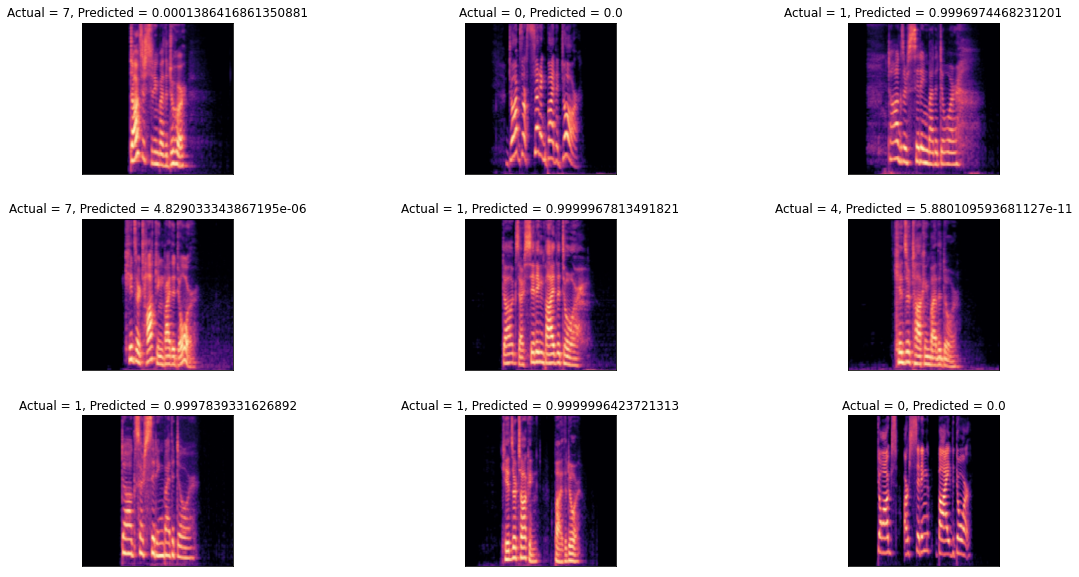

In [212]:
pred = model.predict(x_test)
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [14]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [15]:
IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                4946816   
_________________________________________________________________
sequential_2 (Sequential)    (None, 227, 227, 3)       5101371   
Total params: 10,048,187
Trainable params: 10,048,187
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

Epoch 1/20
36/36 [==============================] - 5s 153ms/step - loss: 0.0704 - val_loss: 0.0000e+00
Epoch 2/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0181 - val_loss: 0.0000e+00
Epoch 3/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0172 - val_loss: 0.0000e+00
Epoch 4/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0170 - val_loss: 0.0000e+00
Epoch 5/20
36/36 [==============================] - 5s 150ms/step - loss: 0.0167 - val_loss: 0.0000e+00
Epoch 6/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0164 - val_loss: 0.0000e+00
Epoch 7/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0160 - val_loss: 0.0000e+00
Epoch 8/20
36/36 [==============================] - 5s 151ms/step - loss: 0.0156 - val_loss: 0.0000e+00
Epoch 9/20
36/36 [==============================] - 5s 148ms/step - loss: 0.0153 - val_loss: 0.0000e+00
Epoch 10/20
36/36 [==============================] - 5s 149ms/st

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


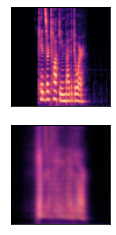

Accuracy= 0.9269862994551659 



In [41]:
decoded_imgs = autoencoder.predict(images)

n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


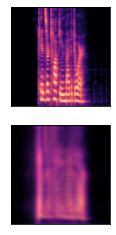

Accuracy= 0.9267575740814209 



In [18]:
decoded_imgs = autoencoder.predict(images)
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(227, 227,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(decoded_imgs, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

x_train shape =  (1152, 227, 227, 3)
y_train shape =  (1152,)

x_test shape =  (288, 227, 227, 3)
y_test shape =  (288,)


In [56]:
%%time
model.fit(X_train, Y_train, epochs=300, batch_size=32)

Epoch 1/300
36/36 [==============================] - 61s 2s/step - loss: 1.9043 - accuracy: 0.3038
Epoch 2/300
36/36 [==============================] - 62s 2s/step - loss: 1.9047 - accuracy: 0.3082
Epoch 3/300
36/36 [==============================] - 62s 2s/step - loss: 1.8784 - accuracy: 0.3151
Epoch 4/300
36/36 [==============================] - 62s 2s/step - loss: 1.8554 - accuracy: 0.3273
Epoch 5/300
36/36 [==============================] - 60s 2s/step - loss: 1.8870 - accuracy: 0.2995
Epoch 6/300
36/36 [==============================] - 71s 2s/step - loss: 1.8368 - accuracy: 0.3108
Epoch 7/300
36/36 [==============================] - 62s 2s/step - loss: 1.8226 - accuracy: 0.3368
Epoch 8/300
36/36 [==============================] - 62s 2s/step - loss: 1.8202 - accuracy: 0.3255
Epoch 9/300
36/36 [==============================] - 62s 2s/step - loss: 1.7897 - accuracy: 0.3464
Epoch 10/300
36/36 [==============================] - 62s 2s/step - loss: 1.8026 - accuracy: 0.3377
Epoch 11/

36/36 [==============================] - 56s 2s/step - loss: 1.3715 - accuracy: 0.4844
Epoch 84/300
36/36 [==============================] - 56s 2s/step - loss: 1.3698 - accuracy: 0.4887
Epoch 85/300
36/36 [==============================] - 56s 2s/step - loss: 1.3132 - accuracy: 0.4852
Epoch 86/300
36/36 [==============================] - 56s 2s/step - loss: 1.5477 - accuracy: 0.4306
Epoch 87/300
36/36 [==============================] - 56s 2s/step - loss: 1.5737 - accuracy: 0.4080
Epoch 88/300
36/36 [==============================] - 55s 2s/step - loss: 1.4763 - accuracy: 0.4149
Epoch 89/300
36/36 [==============================] - 56s 2s/step - loss: 1.4653 - accuracy: 0.4436
Epoch 90/300
36/36 [==============================] - 57s 2s/step - loss: 1.4011 - accuracy: 0.4661
Epoch 91/300
36/36 [==============================] - 54s 2s/step - loss: 1.3526 - accuracy: 0.4818
Epoch 92/300
36/36 [==============================] - 54s 1s/step - loss: 1.3650 - accuracy: 0.4783
Epoch 93/300


36/36 [==============================] - 54s 2s/step - loss: 0.6815 - accuracy: 0.7543
Epoch 246/300
36/36 [==============================] - 54s 1s/step - loss: 0.6791 - accuracy: 0.7387
Epoch 247/300
36/36 [==============================] - 54s 1s/step - loss: 0.6428 - accuracy: 0.7500
Epoch 248/300
36/36 [==============================] - 53s 1s/step - loss: 0.6664 - accuracy: 0.7526
Epoch 249/300
36/36 [==============================] - 54s 1s/step - loss: 0.6944 - accuracy: 0.7387
Epoch 250/300
36/36 [==============================] - 54s 1s/step - loss: 0.7087 - accuracy: 0.7344
Epoch 251/300
36/36 [==============================] - 54s 1s/step - loss: 0.6790 - accuracy: 0.7370
Epoch 252/300
36/36 [==============================] - 53s 1s/step - loss: 0.7077 - accuracy: 0.7378
Epoch 253/300
36/36 [==============================] - 54s 1s/step - loss: 0.8419 - accuracy: 0.6970
Epoch 254/300
36/36 [==============================] - 54s 1s/step - loss: 0.8701 - accuracy: 0.6866
Epoc

In [57]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 673.41796875
Test accuracy: 0.2118055522441864


In [42]:
predictions_new = model.predict_classes(X_test)
predictions_new
y_test
new_Ytest_new = y_test.astype(int)
new_Ytest_new

array([1, 1, 0, 1, 0, 4, 3, 1, 1, 6, 7, 4, 2, 3, 3, 5, 2, 3, 7, 4, 3, 7,
       0, 1, 4, 7, 7, 5, 3, 2, 0, 4, 4, 2, 1, 0, 1, 3, 1, 1, 0, 5, 2, 3,
       2, 0, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 4, 2, 0, 1, 6, 2, 2, 4, 7,
       7, 4, 6, 4, 7, 0, 6, 6, 7, 3, 0, 6, 0, 1, 3, 3, 7, 7, 3, 3, 4, 4,
       7, 2, 0, 0, 0, 2, 6, 5, 3, 2, 4, 7, 0, 1, 1, 1, 6, 4, 0, 4, 7, 0,
       4, 0, 4, 0, 1, 6, 4, 1, 0, 6, 1, 1, 7, 1, 3, 7, 2, 2, 6, 6, 1, 2,
       2, 2, 2, 5, 4, 0, 1, 6, 0, 7, 1, 1, 5, 5, 3, 7, 6, 6, 2, 2, 6, 4,
       6, 5, 7, 2, 3, 1, 3, 1, 6, 5, 3, 1, 0, 4, 7, 5, 0, 6, 4, 2, 2, 2,
       4, 2, 6, 1, 1, 6, 4, 7, 7, 2, 1, 6, 7, 2, 7, 0, 2, 1, 5, 3, 4, 5,
       4, 7, 3, 6, 0, 2, 7, 0, 7, 3, 1, 4, 0, 6, 2, 4, 4, 1, 4, 3, 3, 5,
       1, 3, 7, 3, 3, 2, 3, 3, 2, 5, 1, 5, 1, 3, 0, 2, 6, 0, 3, 4, 3, 3,
       1, 4, 1, 7, 2, 0, 7, 0, 0, 3, 0, 7, 2, 4, 0, 0, 6, 5, 3, 5, 6, 2,
       6, 6, 0, 7, 3, 7, 0, 7, 5, 6, 3, 3, 7, 6, 7, 4, 6, 4, 1, 0, 1, 0,
       1, 6])

In [43]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest_new, predictions_new)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.17      0.95      0.29        43
           2       0.00      0.00      0.00        38
           3       0.11      0.10      0.11        40
           4       0.50      0.03      0.05        35
           5       0.00      0.00      0.00        19
           6       0.12      0.03      0.05        35
           7       0.50      0.03      0.05        37

    accuracy                           0.17       288
   macro avg       0.18      0.14      0.07       288
weighted avg       0.18      0.17      0.08       288



c:\users\shireen\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
